In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns
import trackpy as tp
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

import sys
sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [3]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_*/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_*/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_plots\\20231005_1_IP_GFPCAAX-CheHis_us_8p6/'

In [4]:
micron_size=553.57
pixel_size=1024

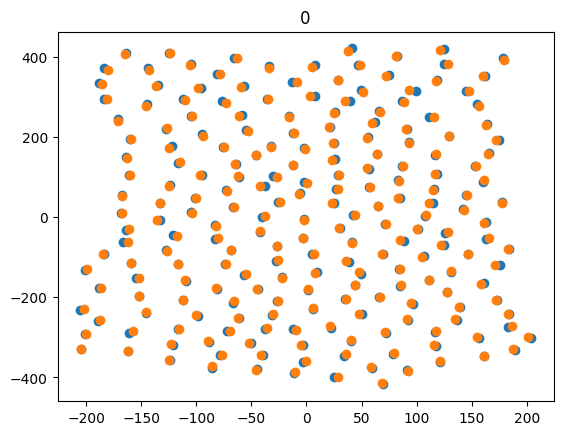

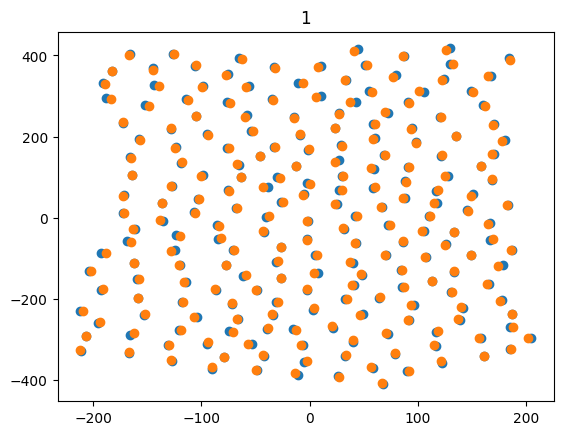

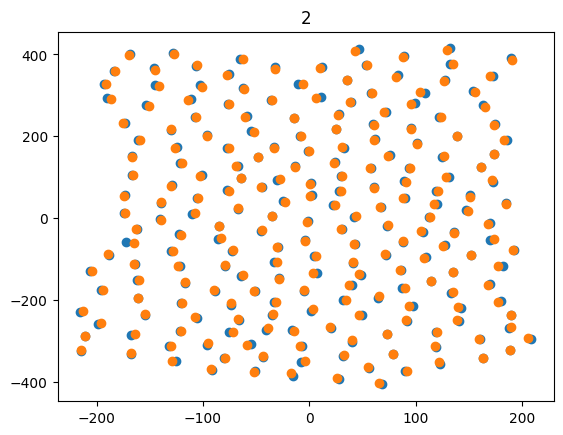

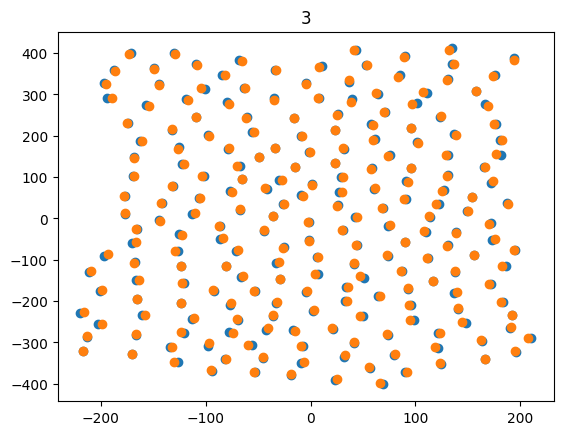

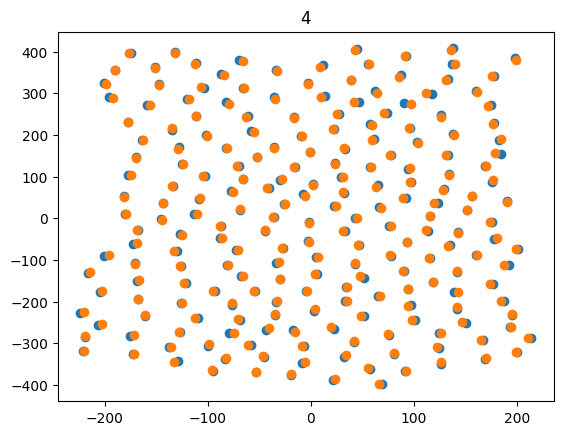

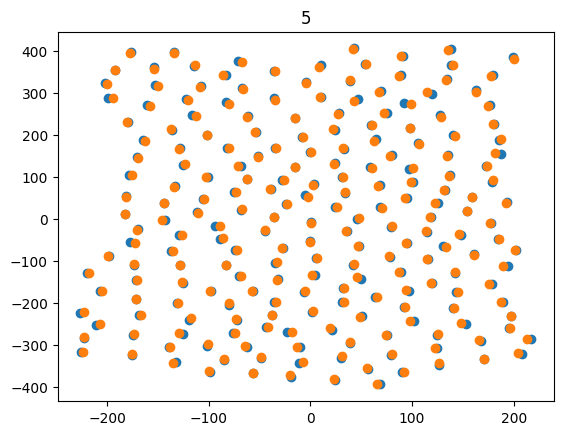

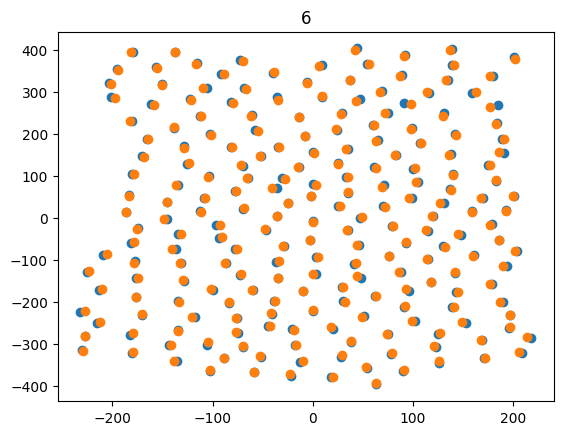

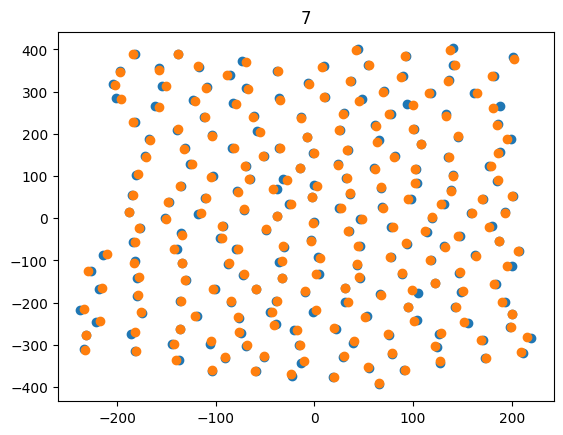

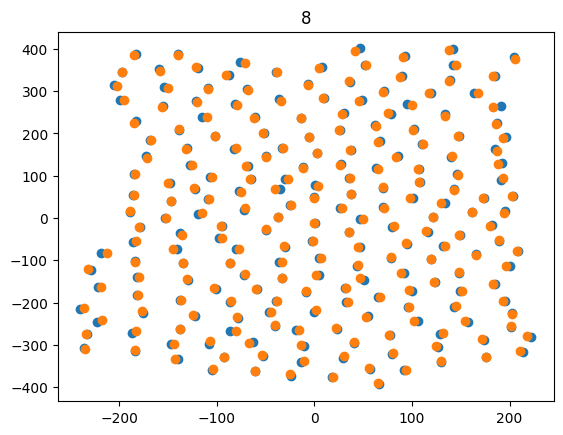

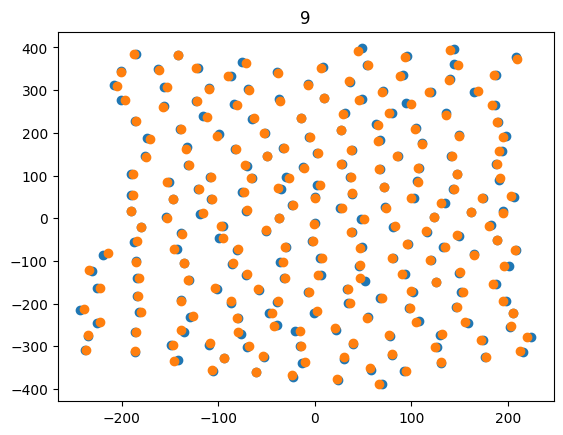

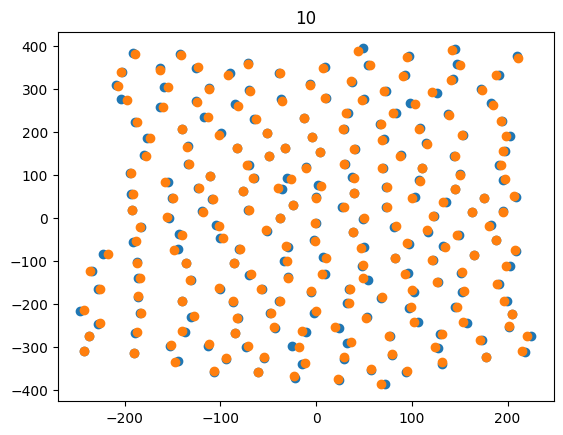

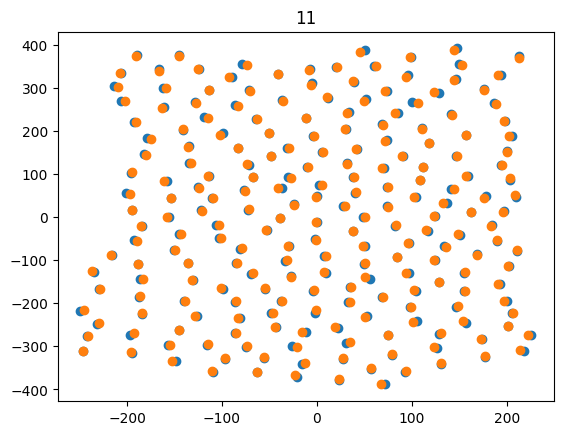

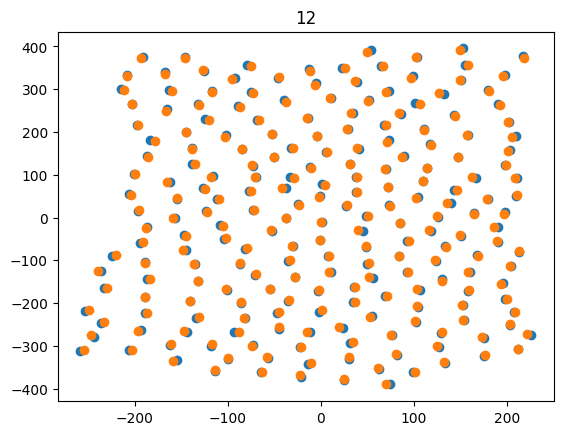

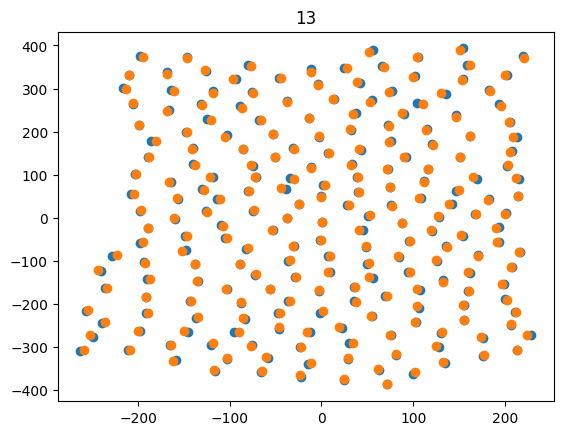

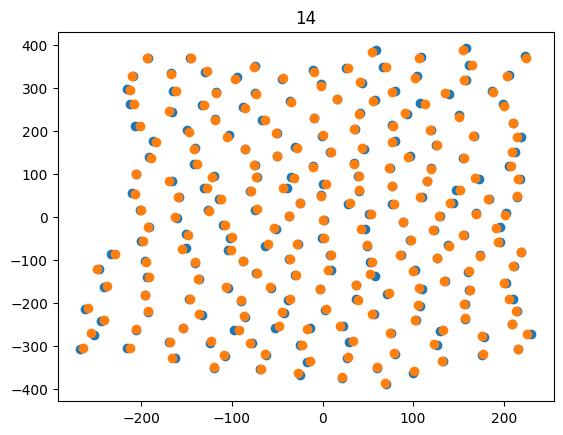

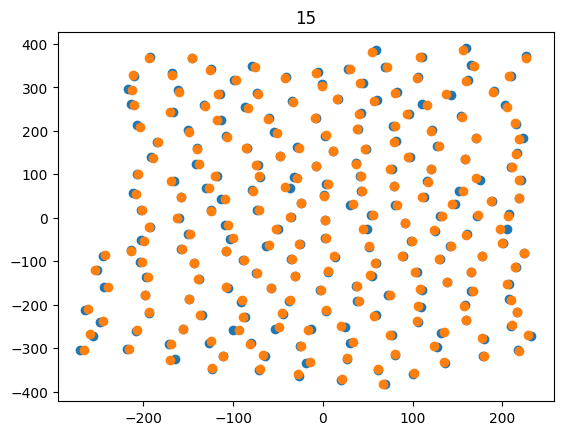

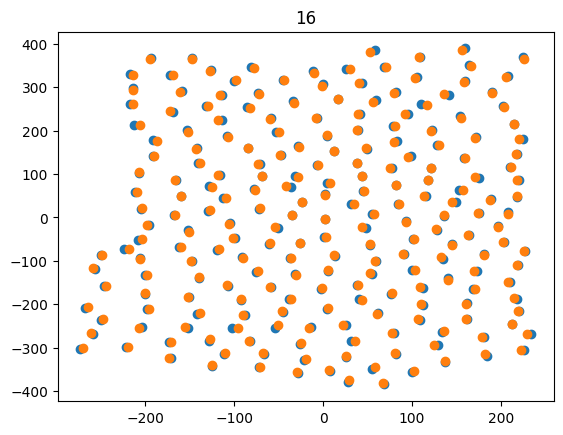

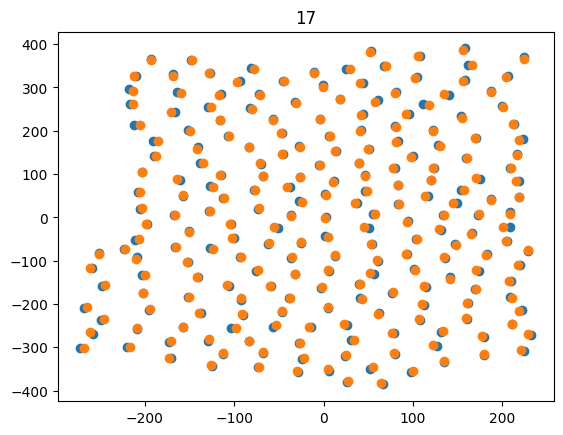

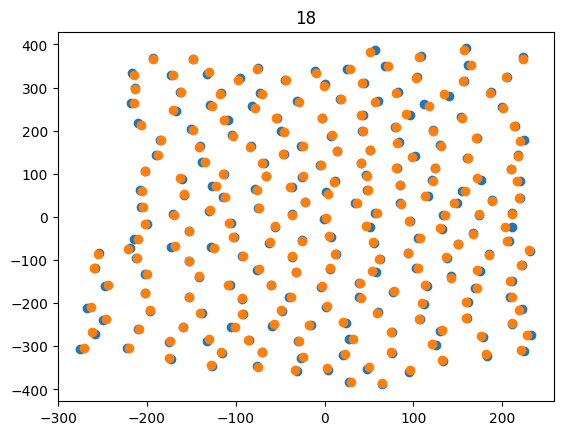

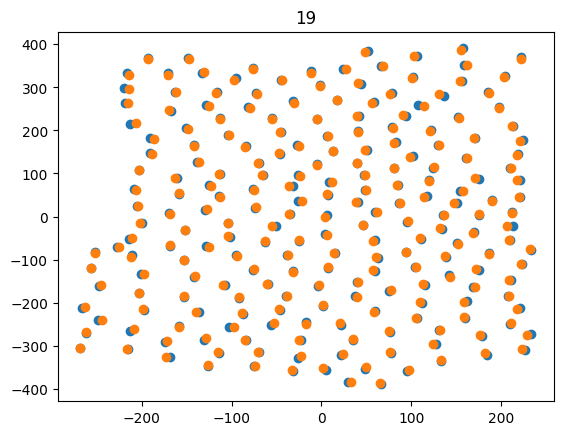

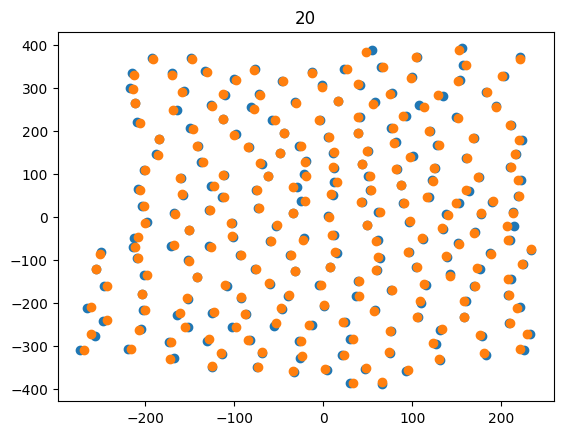

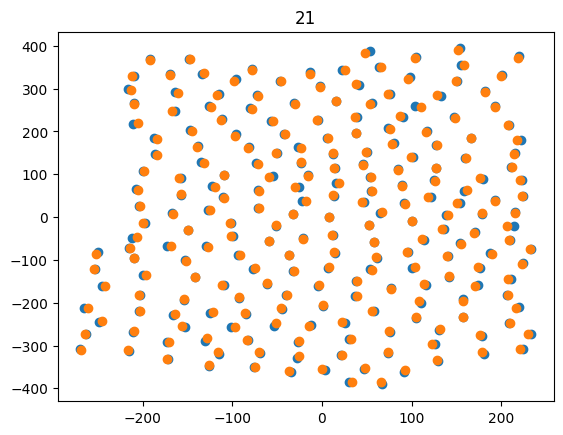

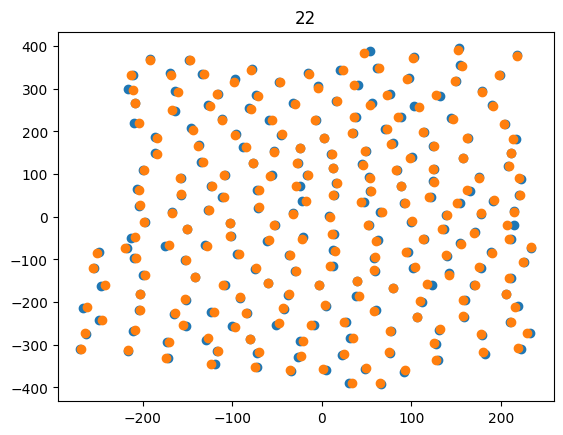

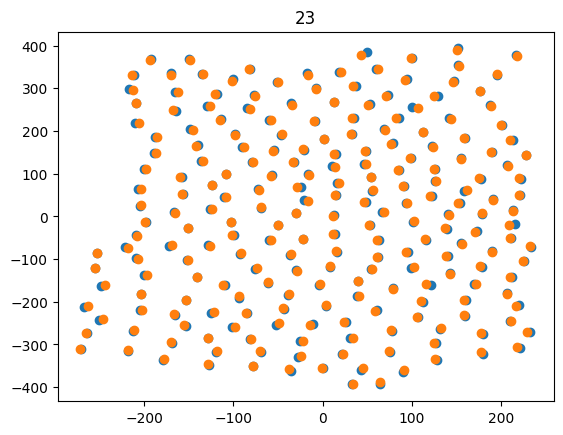

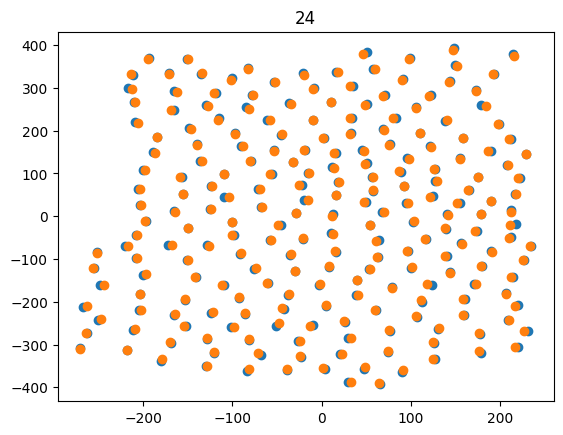

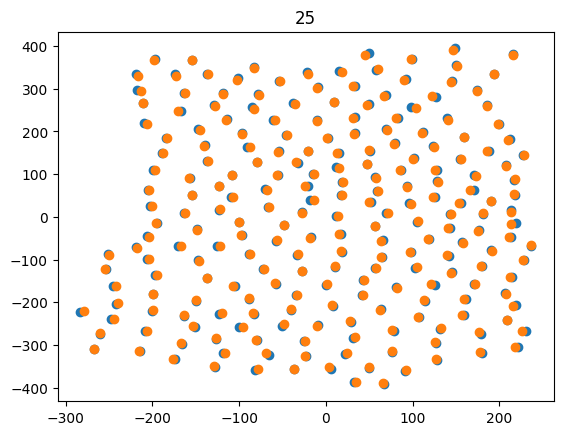

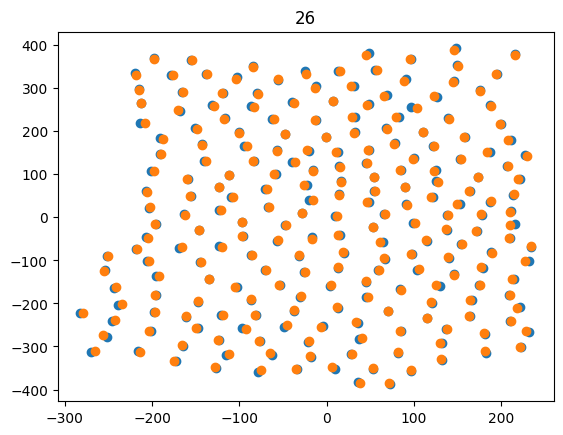

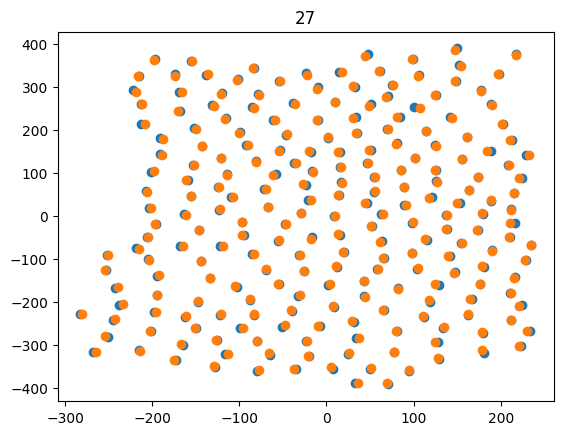

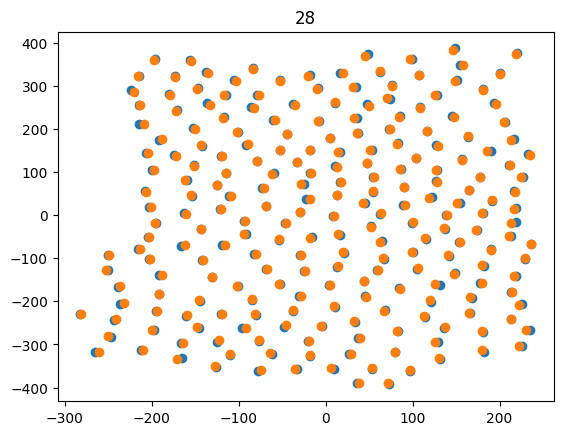

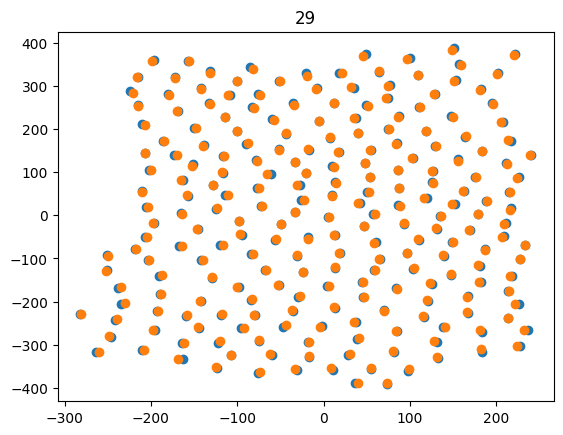

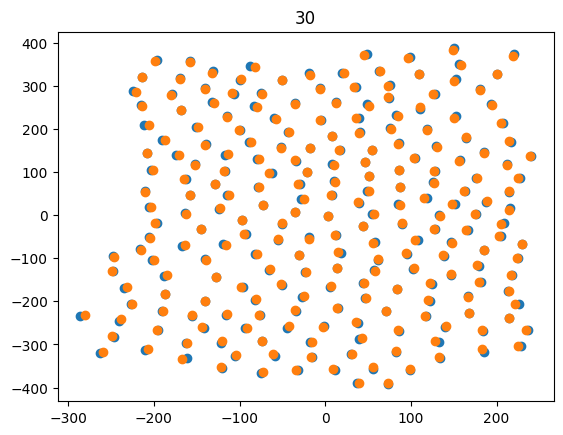

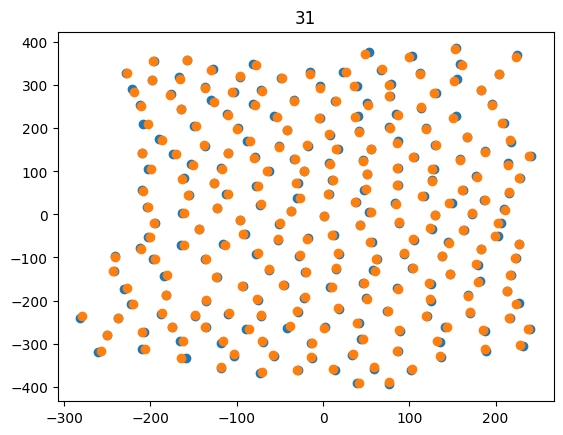

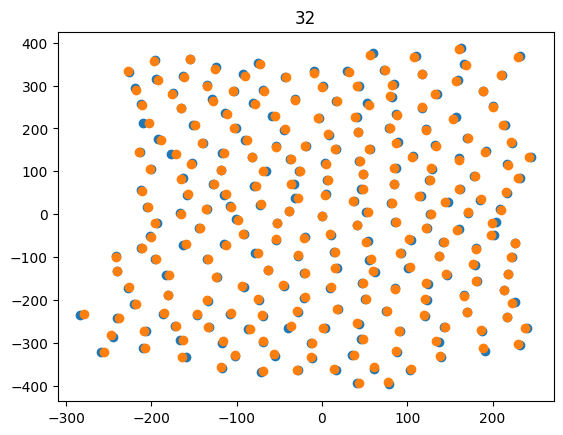

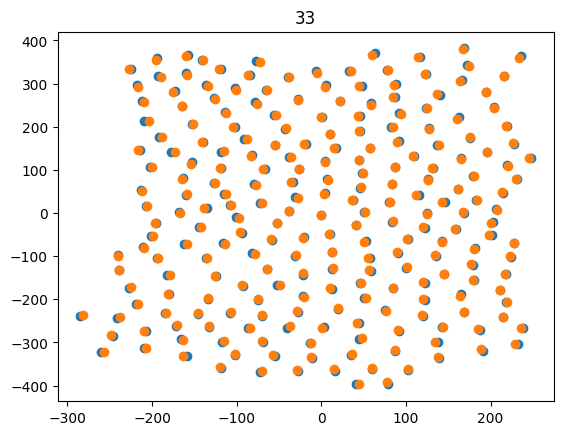

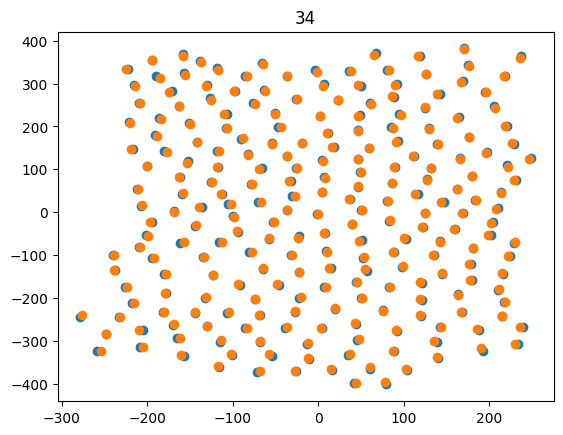

In [5]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/traces/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/traces/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/traces/green_edges/tm_edges.csv', skiprows=[1,2,3])

cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    # if i<20:
    #     scale_factor=0.72-0.0035*i
    # else:
    #     scale_factor=0.725-0.0018*i

    scale_factor=1.025

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    plt.scatter(cc[:,0], cc[:,1])
    plt.scatter(tm_cc[:,0], tm_cc[:,1])
    plt.title(str(i))
    plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)
dat_df.to_csv(save_folder+"/20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP_pooled.csv",index=False)

In [52]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [6]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]
div_list=np.unique(dat_df.parent_id)[~np.isnan(np.unique(dat_df.parent_id))]
#no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(dat_files))[0])]



div_cells=dat_df[(dat_df.cell_id_new.isin(div_list))]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [9]:
cell_dat=dat_df.groupby('cell_id_new').min().time.to_frame()
dat_mi=dat_df.set_index(['cell_id_new','time'])
dat_mi['dx0']=dat_mi.cc_x-dat_df.groupby('cell_id_new').first().cc_x
dat_mi['dy0']=dat_mi.cc_y-dat_df.groupby('cell_id_new').first().cc_y
dat_mi['ds0']=np.sqrt(dat_mi.dx0**2 +dat_mi.dy0**2)
dat_mi['ds0_sq']=dat_mi.dx0**2 +dat_mi.dy0**2
cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_13460\3339878596.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_13460\4028117221.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


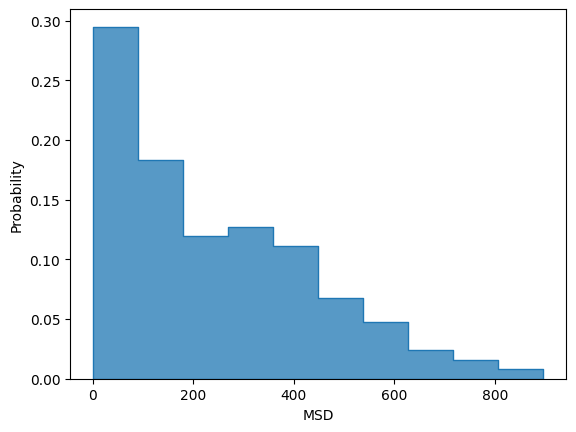

In [10]:
fig, ax=plt.subplots()
g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


plt.savefig(plot_dir+'/MSD.png', dpi=300, bbox_inches='tight')

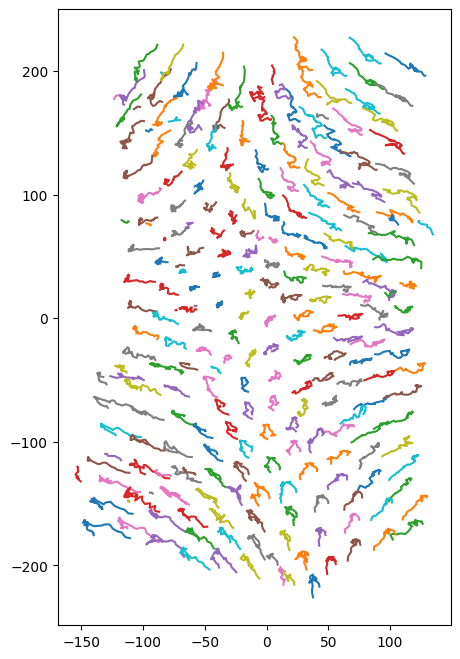

In [11]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in range(np.max(dat_df.cell_id_new)):
    plt.plot(dat_df[dat_df.cell_id_new==i].cc_x, dat_df[dat_df.cell_id_new==i].cc_y)
ax.set_aspect('equal')

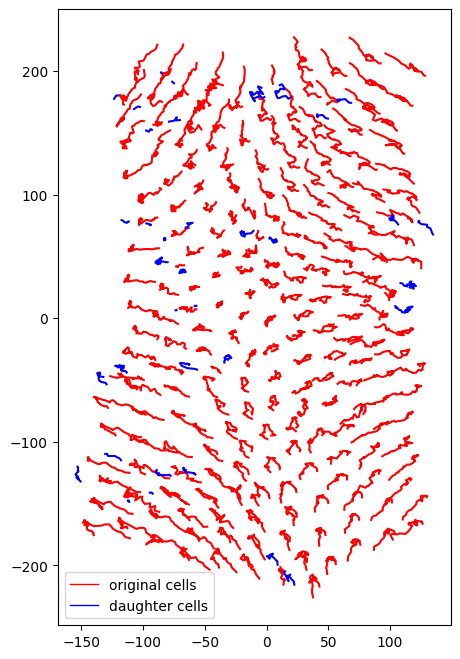

In [7]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

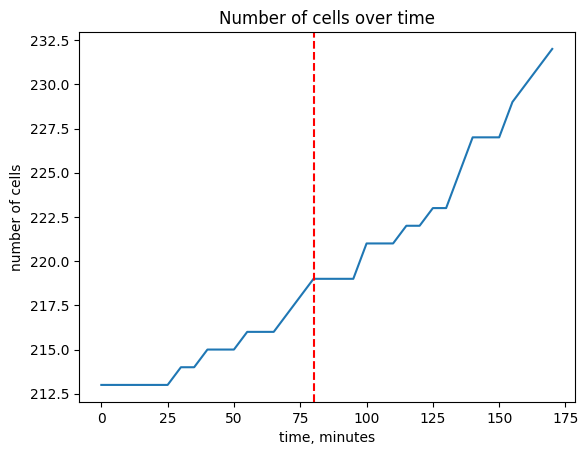

In [13]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

cell_id_old  cell_perimeter_microns  cell_area_microns  \
cell_id_new                                                           
0                     19                      19                 19   
1                     19                      19                 19   
2                     19                      19                 19   
4                     15                      15                 15   
5                     19                      19                 19   
...                  ...                     ...                ...   
246                   19                      19                 19   
247                   19                      19                 19   
248                   19                      19                 19   
249                    2                       2                  2   
250                    2                       2                  2   

             shape_parameter  circularity  cell_edge_count  \
cell_id_new                                                  
0                         19           19               19   
1                         19           19               19   
2                         19           19               19   
4                         15           15               15   
5                         19           19               19   
...                      ...          ...              ...   
246                       19           19               19   
247                       19           19               19   
248                       19           19               19   
249                        2            2                2   
250                        2            2                2   

             major_shape_axis_alignment_rads  cc_x  cc_y  spot_id  time  \
cell_id_new                                                               
0                                         19    19    19       19    19   
1                                         19    19    19       19    19   
2                                         19    19    19       19    19   
4                                         15    15    15       15    15   
5                                         19    19    19       19    19   
...                                      ...   ...   ...      ...   ...   
246                                       19    19    19       19    19   
247                                       19    19    19       19    19   
248                                       19    19    19       19    19   
249                                        2     2     2        2     2   
250                                        2     2     2        2     2   

             tm_frame  parent_id  divisions  angle_horizontal  area_norm  \
cell_id_new                                                                
0                  19          0         19                19         19   
1                  19          0         19                19         19   
2                  19          0         19                19         19   
4                  15          0         15                15         15   
5                  19          0         19                19         19   
...               ...        ...        ...               ...        ...   
246                19         19         19                19         19   
247                19         19         19                19         19   
248                19         19         19                19         19   
249                 2          2          2                 2          2   
250                 2          2          2                 2          2   

             perimeter_norm  circularity_norm  
cell_id_new                                    
0                        19                19  
1                        19                19  
2                        19                19  
4                        15                15  
5                        19  

In [60]:
dat_str=dat_df[dat_df.time<=80]
no_div_str=dat_str[dat_str.cell_id_new.isin(np.unique(dat_str.cell_id_new)[np.where(dat_str.groupby('cell_id_new').count().time==17)])]
div_str=dat_str[dat_str.cell_id_new.isin(np.unique(dat_str.cell_id_new)[np.where(dat_str.groupby('cell_id_new').count().time<17)])]

dat_rlx=dat_df[dat_df.time>=80]
no_div_rlx=dat_rlx[dat_rlx.cell_id_new.isin(np.unique(dat_rlx.cell_id_new)[np.where(dat_rlx.groupby('cell_id_new').count().time==19)])]
div_rlx=dat_rlx[dat_rlx.cell_id_new.isin(np.unique(dat_rlx.cell_id_new)[np.where(dat_rlx.groupby('cell_id_new').count().time<19)])]



In [61]:
nds_t0=no_div_str[no_div_str.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nds_t80=no_div_str[no_div_str.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

ndr_t80=no_div_rlx[no_div_rlx.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
ndr_t170=no_div_rlx[no_div_rlx.tm_frame==np.max(dat_df.tm_frame)][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

cc_us=pd.merge(nds_t0, nds_t80, on='cell_id_new', suffixes=("_u", "_s"))
cc_us['cc_dx']=cc_us.cc_x_s-cc_us.cc_x_u
cc_us['cc_dy']=cc_us.cc_y_s-cc_us.cc_y_u

cc_sr=pd.merge(ndr_t80, ndr_t170, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s

cc_s_0=np.transpose(np.vstack((cc_us.cc_x_u, cc_us.cc_y_u)))
cc_s_80=np.transpose(np.vstack((cc_us.cc_x_s, cc_us.cc_y_s)))
aft=np.array(cv2.estimateAffine2D(cc_s_0, cc_s_80, method=cv2.RANSAC)[0][:,:2])
print(aft)
print(polar(aft))

cc_r_80=np.transpose(np.vstack((cc_sr.cc_x_s, cc_sr.cc_y_s)))
cc_r_170=np.transpose(np.vstack((cc_sr.cc_x_r, cc_sr.cc_y_r)))
aft=np.array(cv2.estimateAffine2D(cc_r_80, cc_r_170, method=cv2.RANSAC)[0][:,:2])
print(aft)
print(polar(aft))

[[ 1.25333623  0.0537638 ]
 [-0.01926275  0.91075072]]
(array([[ 0.99943113,  0.03372554],
       [-0.03372554,  0.99943113]]), array([[1.25327289, 0.02301765],
       [0.02301765, 0.91204584]]))
[[ 1.01044001 -0.00363464]
 [-0.03255632  1.0165864 ]]
(array([[ 0.99989823,  0.01426658],
       [-0.01426658,  0.99989823]]), array([[ 1.01080164, -0.01813748],
       [-0.01813748,  1.01643109]]))


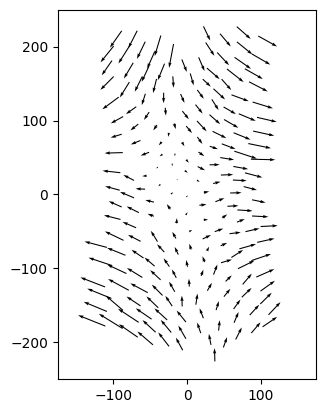

In [22]:
dx= cc_us.cc_dx
dy=cc_us.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_us.cc_x_u,cc_us.cc_y_u, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-175,175)
plt.ylim(-250,250)

plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_stretch.png', dpi=300, bbox_inches='tight')

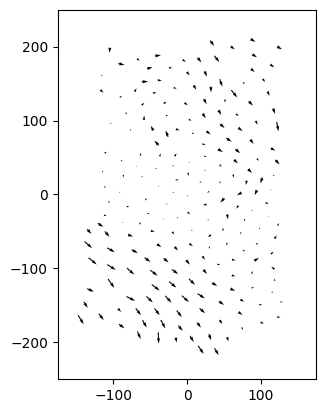

In [23]:
dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-175,175)
plt.ylim(-250,250)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_relaxation.png', dpi=300, bbox_inches='tight')

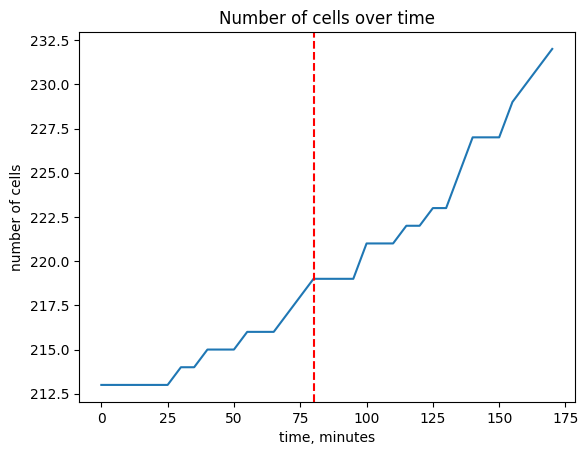

In [24]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

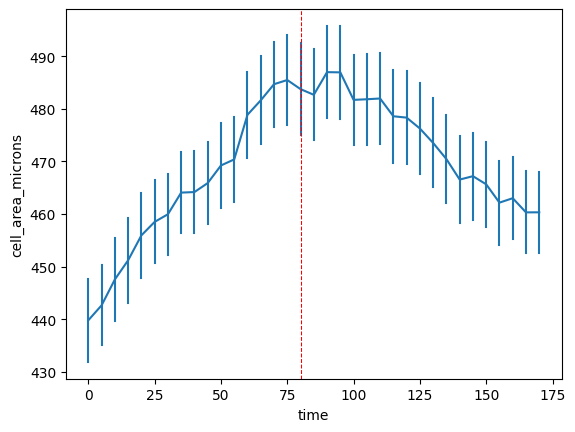

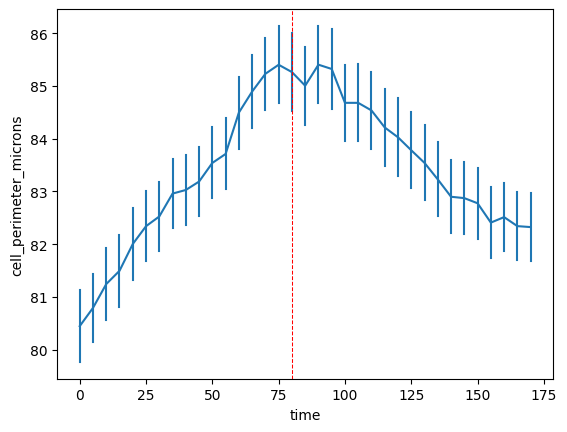

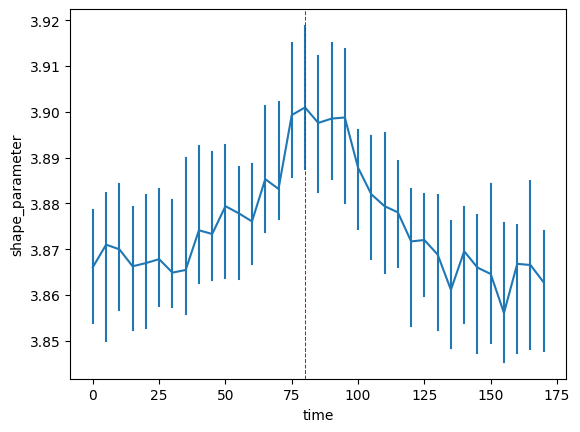

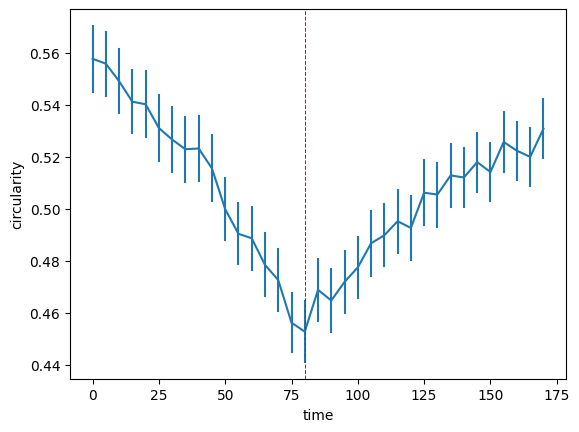

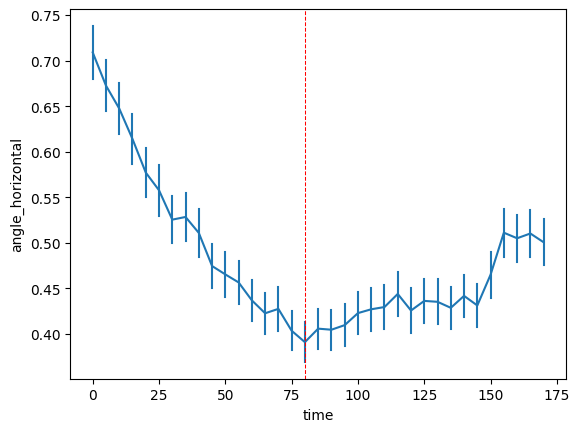

In [25]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

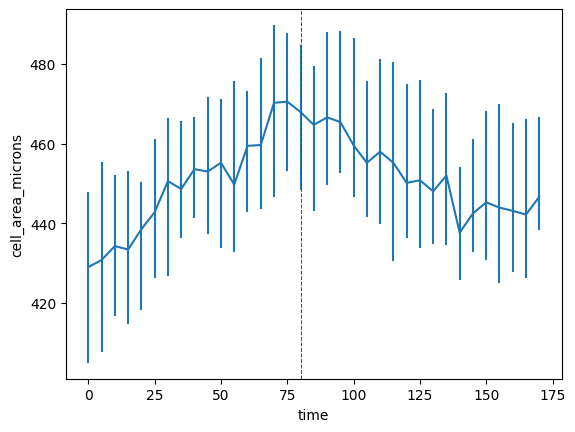

In [26]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()

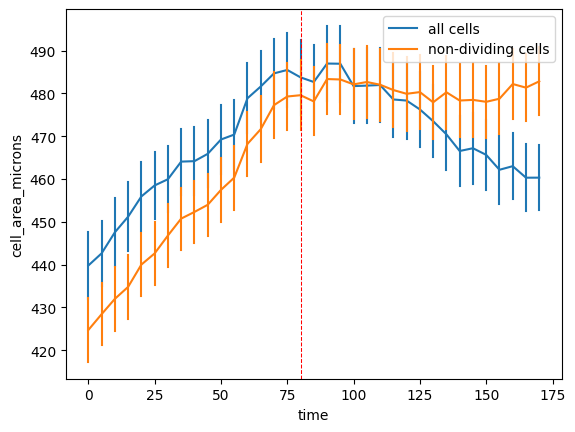

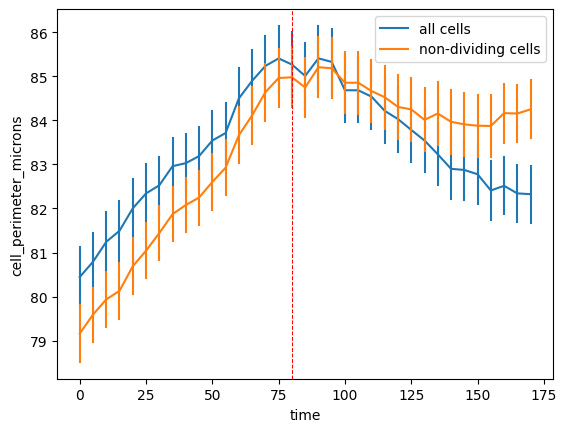

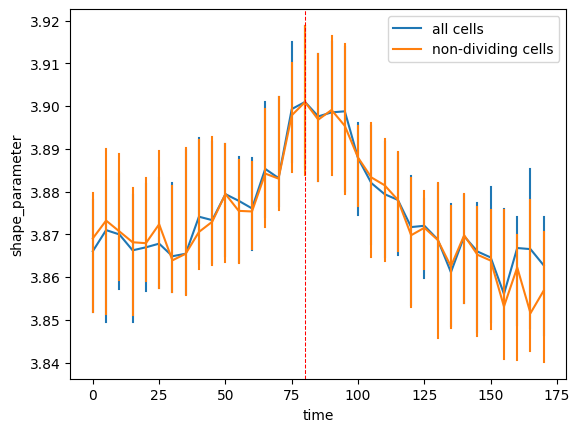

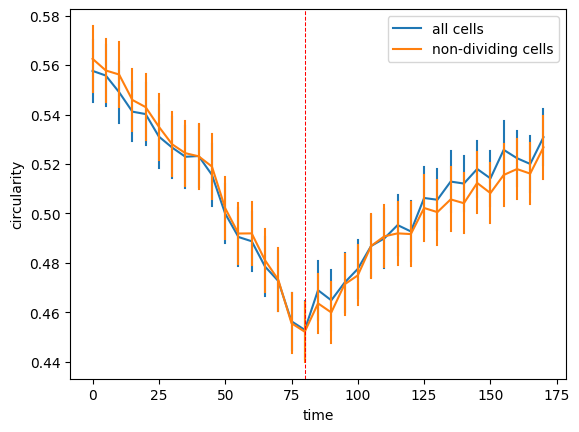

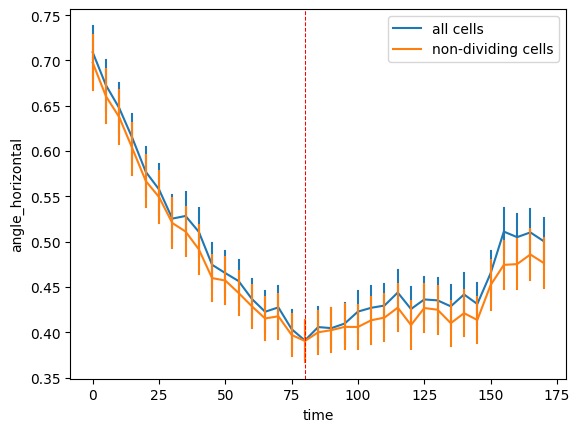

In [27]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

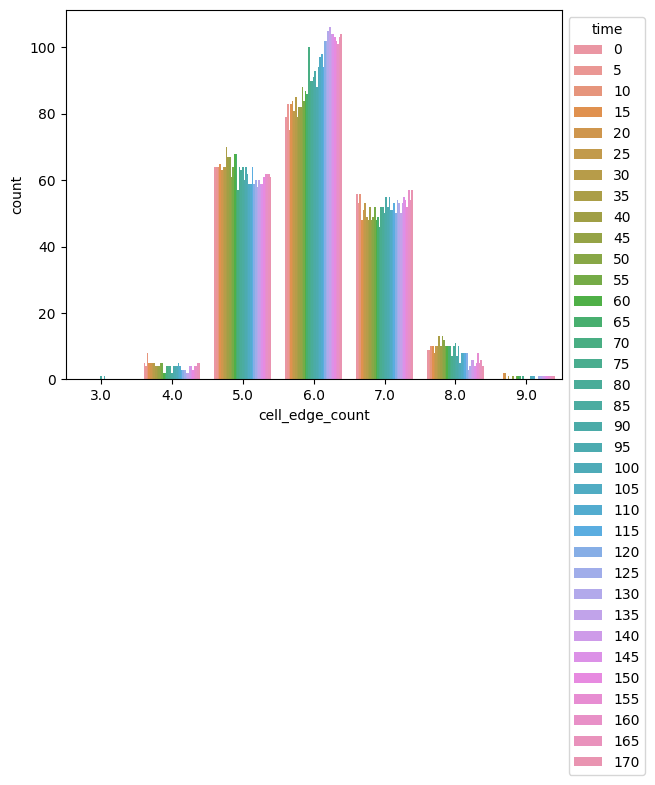

In [28]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

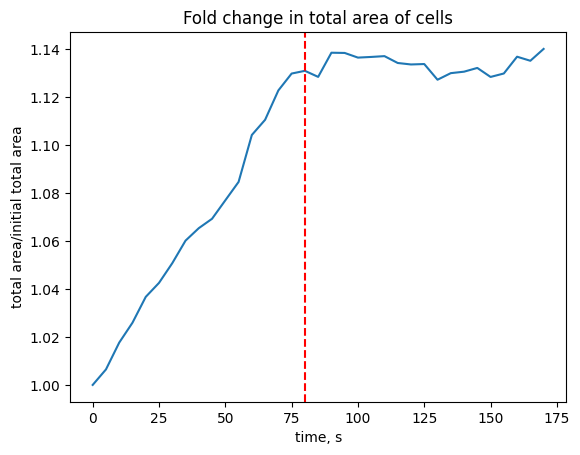

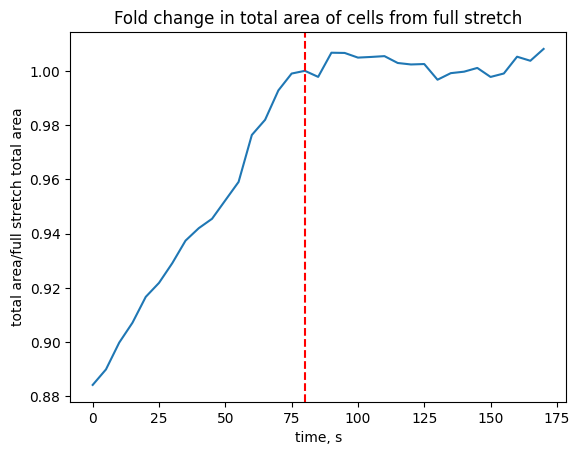

In [29]:
t=np.linspace(0, 170, 35)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

t=np.linspace(0, 170, 35)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==80].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/full stretch total area")
plt.title("Fold change in total area of cells from full stretch")
plt.savefig(plot_dir+'/total_area_full_stretch.png', dpi=300, bbox_inches='tight')

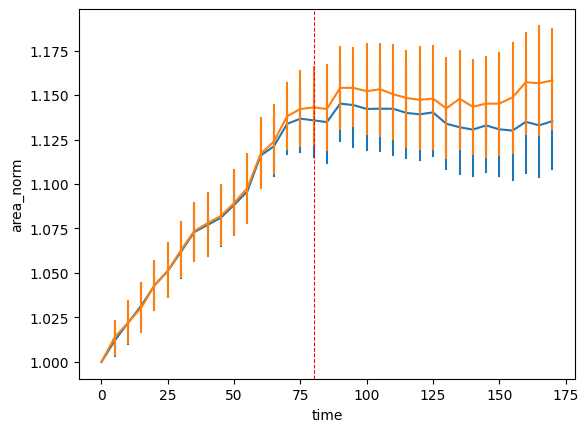

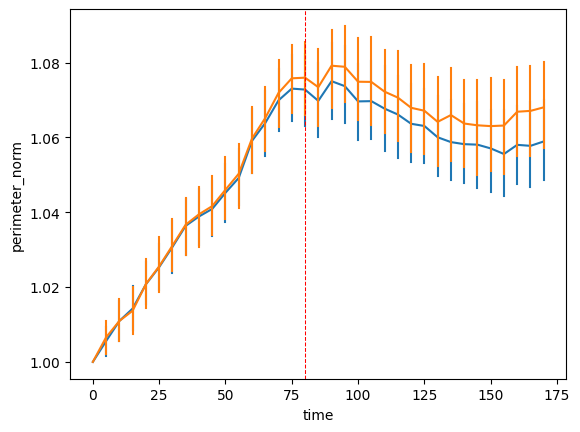

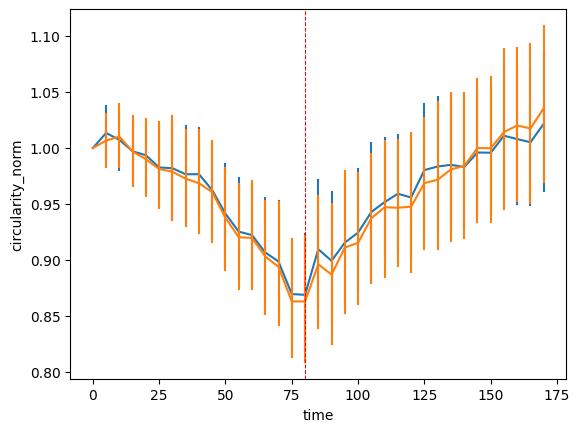

In [30]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()


sns.lineplot(data=dat_df, y='circularity_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='circularity_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circ_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

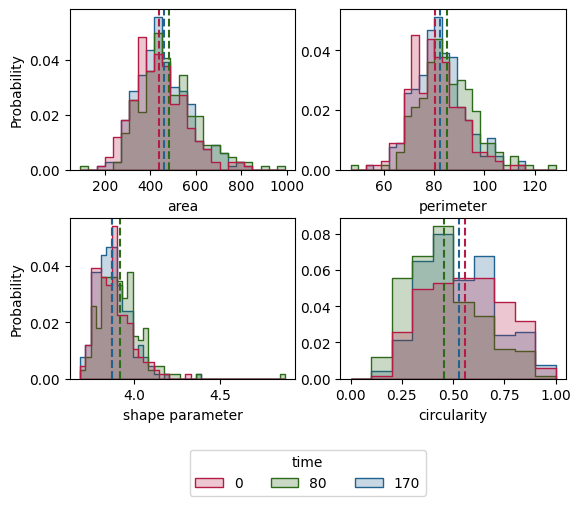

In [31]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='cell_area_microns', stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==170].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='cell_perimeter_microns', stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==170].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='circularity', stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==170].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='shape_parameter', stat='probability', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==170].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

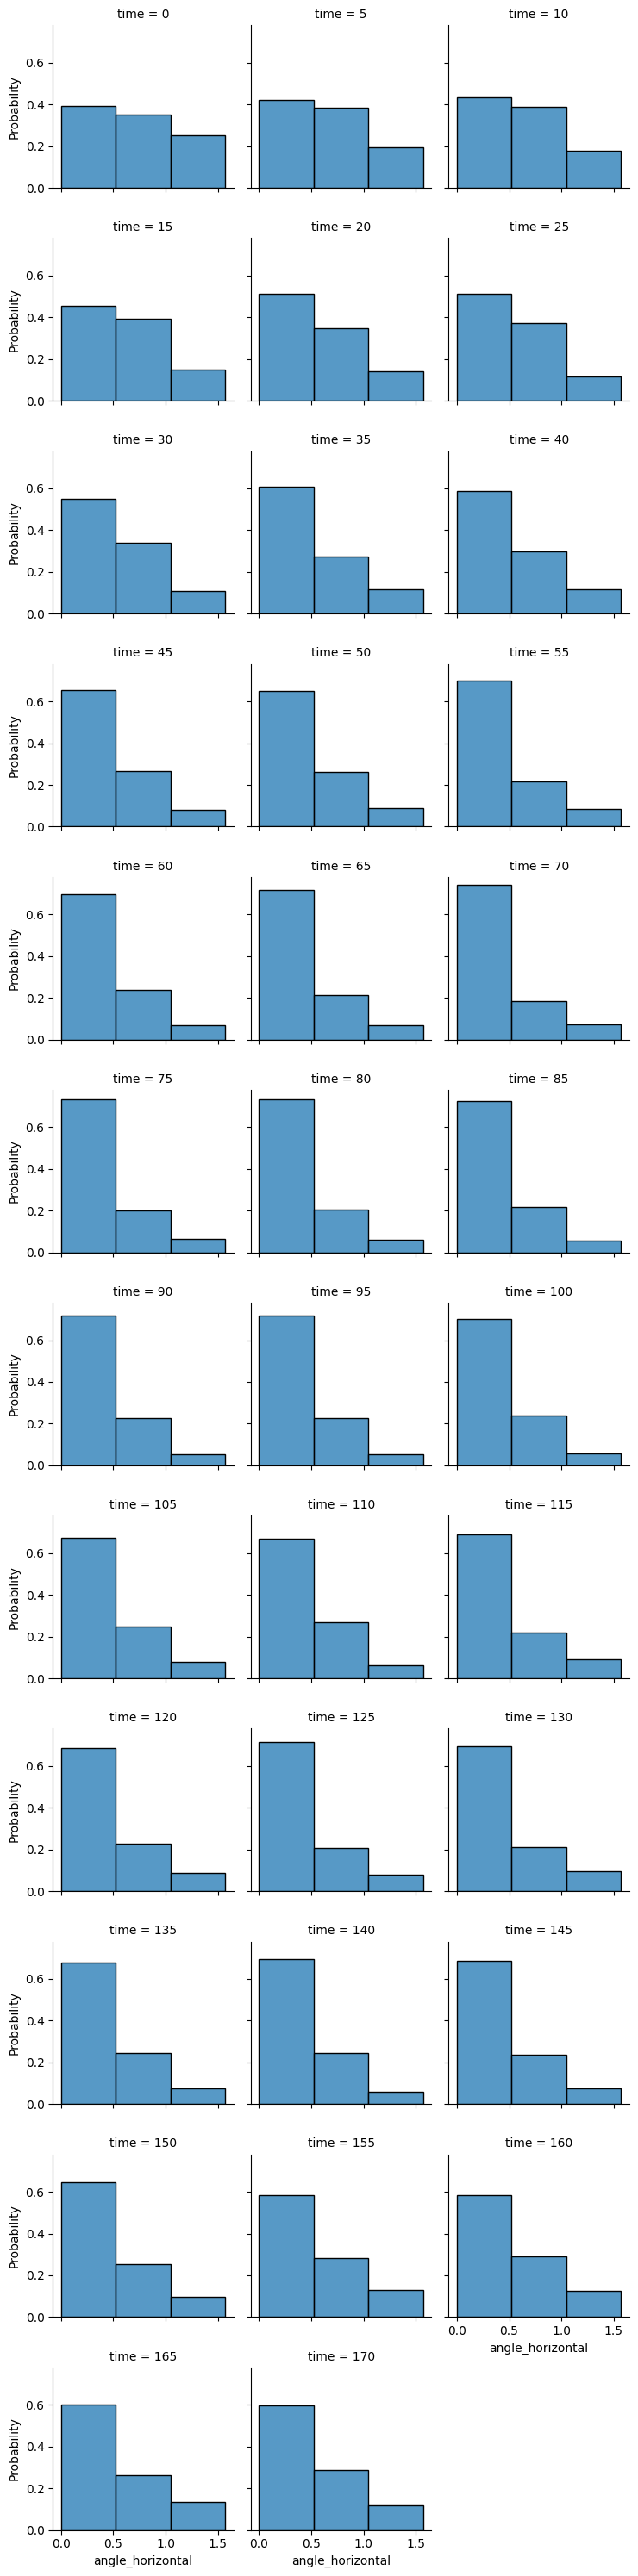

In [32]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

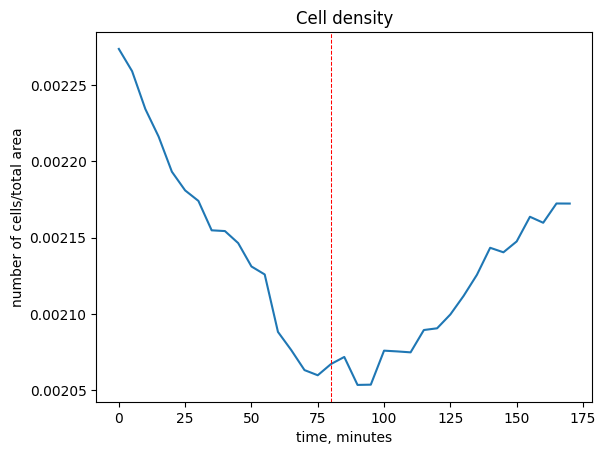

In [33]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

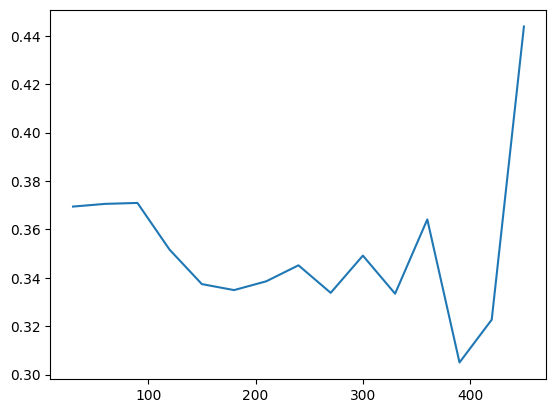

In [34]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==0].cc_y.values, dat_df[dat_df.time==0].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape.r.max(), 30)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

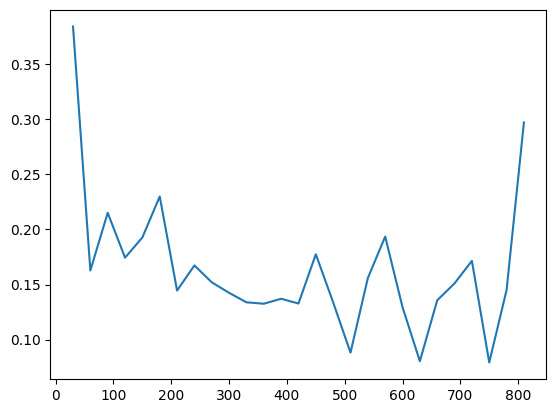

In [11]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==80].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==80].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==80].cc_x.values, dat_df[dat_df.time==80].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==80].cc_y.values, dat_df[dat_df.time==80].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape.r.max(), 30)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

In [35]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_13460\2948227597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')


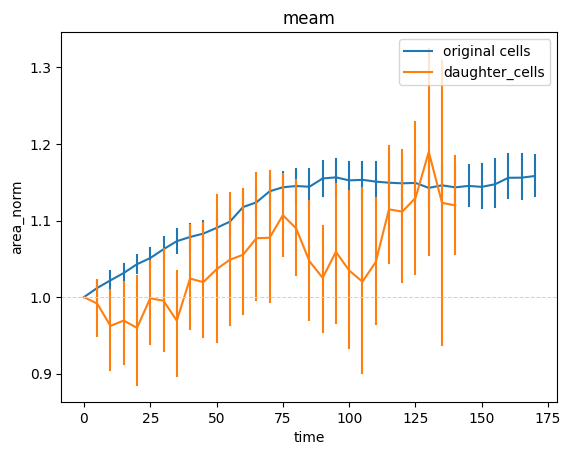

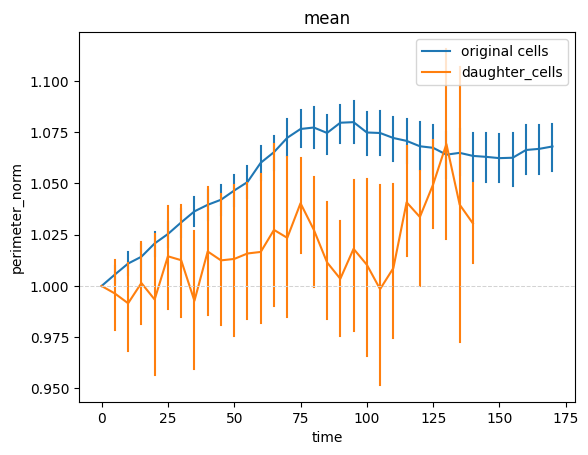

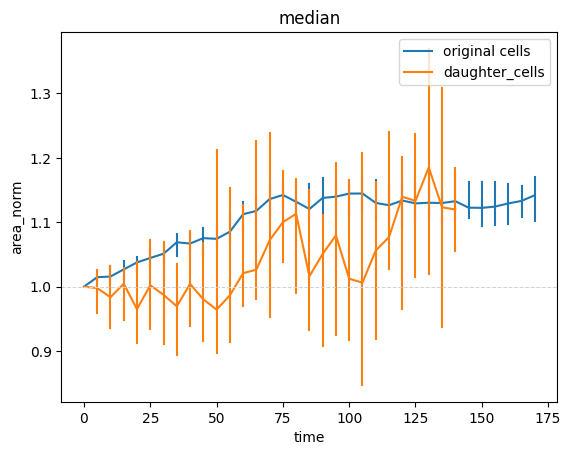

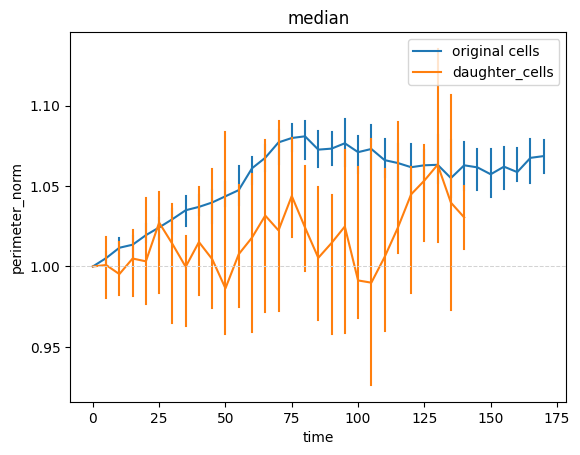

In [36]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('meam')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', estimator='median',label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars',estimator='median', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
dat_df['dx']=dat_df.groupby("cell_id_new").diff().cc_x
dat_df['dy']=dat_df.groupby("cell_id_new").diff().cc_y

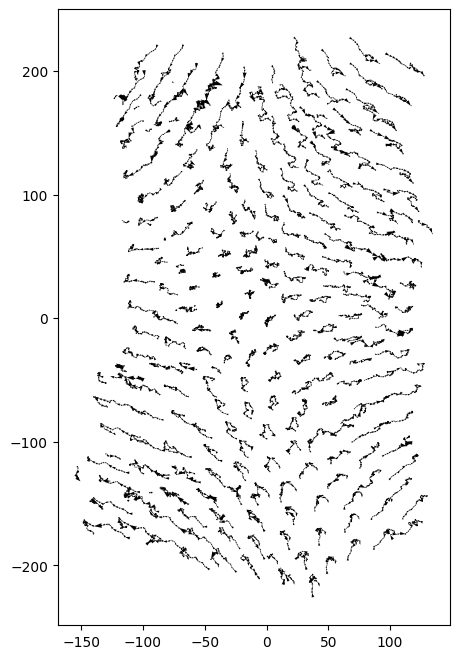

In [9]:
fig,ax=plt.subplots(figsize=(8, 8))

for i in np.unique(dat_df.tm_frame)[:-1]:
    cells=list(set(dat_df[dat_df.tm_frame==i+1].cell_id_new).intersection(set(dat_df[dat_df.tm_frame==i].cell_id_new)))
    cell_fr=dat_df[(dat_df.cell_id_new.isin(cells))]
    ax.quiver(cell_fr[cell_fr.tm_frame==i].cc_x,cell_fr[cell_fr.tm_frame==i].cc_y, cell_fr[cell_fr.tm_frame==i+1].dx,cell_fr[cell_fr.tm_frame==i+1].dy,units='xy', angles='xy', scale=1, zorder=10)

ax.set_aspect('equal')

In [10]:
traj_dat=dat_df[['cc_x', 'cc_y', 'tm_frame', 'cell_id_new']]
traj_dat=traj_dat.rename(columns={"cc_y": "y", "cc_x": "x", "tm_frame":"frame", "cell_id_new":"particle"})

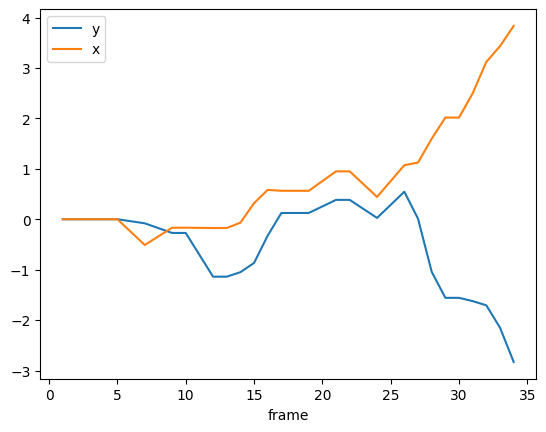

In [25]:
d = tp.compute_drift(traj_dat,2)
d.plot()
plt.show()

In [26]:
tm = tp.subtract_drift(traj_dat.copy(), d)
tm['dx']=tm.groupby('particle').diff().x
tm['dy']=tm.groupby('particle').diff().y
tm['vtheta']=np.arctan2(tm.dy, tm.dx)
tm['ds']=np.sqrt(tm.dx**2+tm.dy**2)

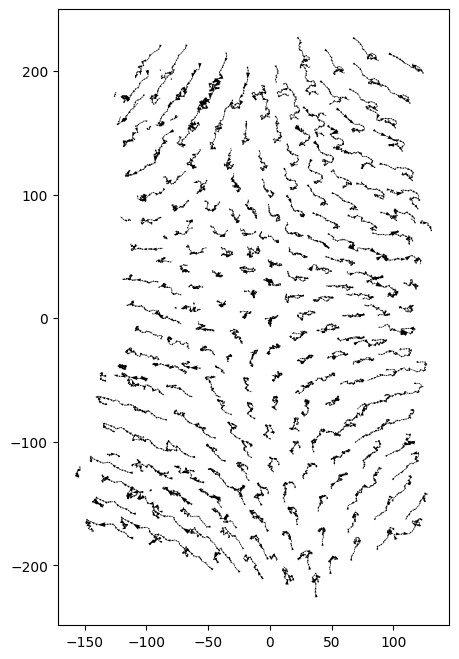

In [27]:
fig,ax=plt.subplots(figsize=(8, 8))

for i in np.unique(tm.frame)[:-1]:
    cells=list(set(tm[tm.frame==i+1].particle).intersection(set(tm[tm.frame==i].particle)))
    cell_fr=tm[(tm.particle.isin(cells))]
    ax.quiver(cell_fr[cell_fr.frame==i].x,cell_fr[cell_fr.frame==i].y, cell_fr[cell_fr.frame==i+1].dx,cell_fr[cell_fr.frame==i+1].dy,units='xy', angles='xy', scale=1, zorder=10)

ax.set_aspect('equal')

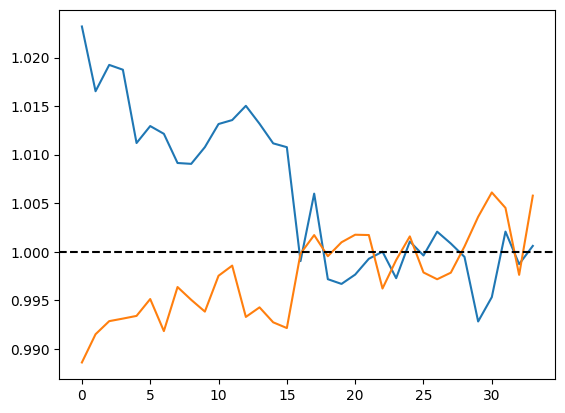

In [53]:
trans=[]
for i in np.unique(dat_df.tm_frame)[:-1]:
    cells=list(set(dat_df[dat_df.tm_frame==i+1].cell_id_new).intersection(set(dat_df[dat_df.tm_frame==i].cell_id_new)))
    cell_fr=dat_df[(dat_df.cell_id_new.isin(cells))]
    cc_i=np.transpose(np.vstack((cell_fr[cell_fr.tm_frame==i].cc_x, cell_fr[cell_fr.tm_frame==i].cc_y)))
    cc_f=np.transpose(np.vstack((cell_fr[cell_fr.tm_frame==i+1].cc_x, cell_fr[cell_fr.tm_frame==i+1].cc_y)))
    aft=np.array(cv2.estimateAffine2D(cc_i, cc_f, method=cv2.RANSAC)[0][:,:2])
    trans.append(polar(aft)[1].diagonal())
trans=np.array(trans)

plt.plot(trans[:,0])
plt.plot(trans[:,1])
plt.axhline(1,c='k', linestyle='--')

In [58]:
np.cumprod(trans[:,0])
np.cumprod(trans[:,1])


array([0.9885954 , 0.98019663, 0.97319067, 0.96649026, 0.96010521,
       0.95542977, 0.94762142, 0.94417728, 0.93950212, 0.9337106 ,
       0.93140142, 0.93007115, 0.92382838, 0.91853725, 0.91186125,
       0.90469538, 0.90452354, 0.90607409, 0.90565658, 0.9065406 ,
       0.9081296 , 0.90969186, 0.90624612, 0.90546799, 0.90689982,
       0.90496519, 0.90240144, 0.90045614, 0.90093967, 0.90418112,
       0.90970313, 0.91381186, 0.911636  , 0.91690359])

In [ ]:
array([[1.25327289, 0.02301765],
       [0.02301765, 0.91204584]])

In [63]:
tot_F=np.array([[1.25327289,0],[0, 0.91204584]])
cum_F=np.array([[np.cumprod(trans[:,0])[-1], 0], [0, np.cumprod(trans[:,1])[-1]]])

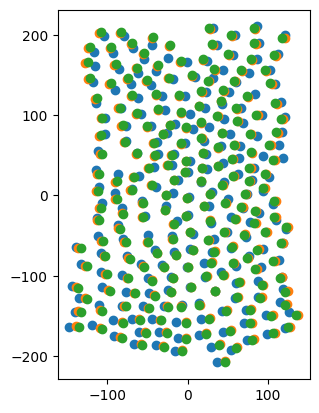

In [70]:
plt.scatter(cc_s_80[:,0], cc_s_80[:,1])
plt.scatter((tot_F@cc_s_0.T).T[:,0],(tot_F@cc_s_0.T).T[:,1])
plt.scatter((cum_F@cc_s_0.T).T[:,0],(cum_F@cc_s_0.T).T[:,1])
plt.gca().set_aspect('equal')

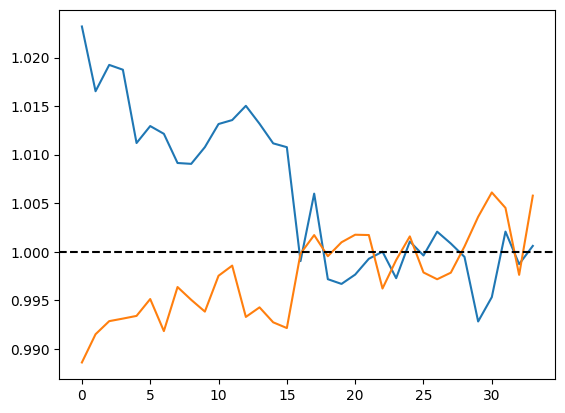

In [48]:
plt.plot(trans[:,0])
plt.plot(trans[:,1])
plt.axhline(1,c='k', linestyle='--')

In [32]:
cc_i=np.transpose(np.vstack((tm[tm.frame==0].x, tm[tm.frame==0].y)))
cc_f=np.transpose(np.vstack((tm[tm.frame==1].x, tm[tm.frame==1].y)))
aft=np.array(cv2.estimateAffine2D(cc_i, cc_f, method=cv2.RANSAC)[0][:,:2])
aft

array([[1.02320917, 0.00752191],
       [0.00473034, 0.98858592]])

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_15464\1441675613.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(dat_df.groupby(['tm_frame']).mean().ds)


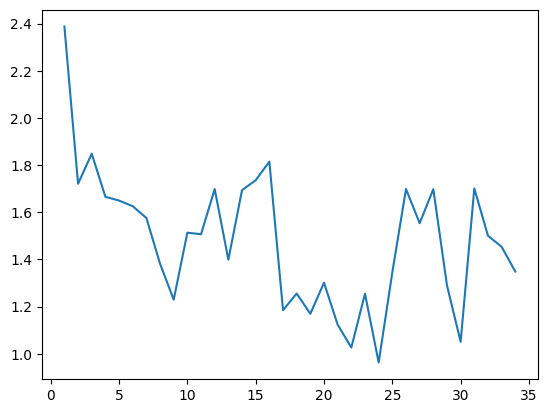

In [54]:
dat_df['dx']=dat_df.groupby('cell_id_new').diff().cc_x
dat_df['dy']=dat_df.groupby('cell_id_new').diff().cc_y
dat_df['vtheta']=np.arctan2(dat_df.dy, dat_df.dx)
dat_df['ds']=np.sqrt(dat_df.dx**2+dat_df.dy**2)
plt.plot(dat_df.groupby(['tm_frame']).mean().ds)

In [1]:
fig,ax=plt.subplots(figsize=(8, 8))

for i in np.unique(dat_df.tm_frame)[:-1]:
    cells=list(set(dat_df[dat_df.tm_frame==i+1].cell_id_new).intersection(set(dat_df[dat_df.tm_frame==i].cell_id_new)))
    cell_fr=dat_df[(dat_df.cell_id_new.isin(cells))]
    ax.stream_plot(cell_fr[cell_fr.tm_frame==i].cc_x,cell_fr[cell_fr.tm_frame==i].cc_y, cell_fr[cell_fr.tm_frame==i+1].dx,cell_fr[cell_fr.tm_frame==i+1].dy)

    ax.set_aspect('equal')
    plt.show()

NameError: name 'plt' is not defined